## Using Clifford algebra to reduce the circuit depth for generating Hamiltonian eigenstates 


*Marc Maußner, Thierry Kaldenbach, Raphael Kopp & Lea Marlen Rektorschek*

## Introduction:

Explain why you have chosen this topic. Why is it interesting? What makes it hard to solve?

The Hamiltonian mixer approach is a technique used in quantum computing to encode and manipulate information within a quantum system.
This approach is particularly useful in the context of chemistry and material science, where the Hamiltonian mixer is utilized to evolve the system gradually towards a desired state $H_0$ that represents the solution to a given hard-to solve problem. [1]
To do so, we define our simulation Hamiltonian like this: <br>
$H = s(t) H_0 + (1-s(t)) H_{mixer}$, where $s$ is the coupling strength between $H_0$ and $H_{mixer}$, $H_0$ defines the Hamiltonian ground state we want to know and  $H_{mixer}$ is the hamiltonian to adiabatically evolve to $H_0$. 
The gradual transformation of $H_{mixer} \Rightarrow H_0$ is done by increasing $s$ over time. Due to the adiabatic theorem, we can start with the efficent to prepare groundstate of $H_{mixer}$ and evolve it over time to obtain the groundstate of $H_0$:
$|\Psi (t) \> = \exp (-i/2 H (t - \tilde t)) |\Psi (\tilde t) \>$.

To run this on a quantum device, the evolution of $s$ is discretized to timesteps $\Delta t$. 


The Gottesman-Knill theorem states that a specific type of quantum circuits called stabilizer circuits can be efficiently simulated on a classical computer.
Stabilizer circuits are circuits based on Clifford gates including the generators $CNOT, H, S$. 


## Idea


Explain what your idea is. Whats your approach in tackling this problem. Explain in detail the general idea, the steps and also why this should lead to a better solution
- With number of gates, fidelity decreasing

## Solution

### "Naive"/default solution

Describe how the naive solution is implemented. If the default solution already has some optimization in it, explain what it is.
And then implement the solution in code. Explain what parameters can be changed in the code below.

[1]: Berry, D.W., Kieferová, M., Scherer, A. et al. Improved techniques for preparing eigenstates of fermionic Hamiltonians. npj Quantum Inf 4, 22 (2018). https://doi.org/10.1038/s41534-018-0071-5 <br>
[2]: Anders, S. and Briegel, H. J., “Fast simulation of stabilizer circuits using a graph-state representation”, Physical Review A, vol. 73, no. 2, 2006. doi:10.1103/PhysRevA.73.022334 


In [1]:
# Importing all the parts we will need.
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit_optimization.applications import Tsp
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA
from qiskit.circuit import Parameter

import warnings
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

warnings.filterwarnings("ignore")

import math

pi = math.pi

## "Naive"/default solution and motivation for our problem

For quantum simulation


We use a simple graph with three nodes for Traveling-Salesman-Problem (TSP) as basic introductory example based on https://github.com/qiskit-community/qiskit-optimization/blob/stable/0.5/docs/tutorials/06_examples_max_cut_and_tsp.ipynb

This is done by mapping our TSP to the Ising model to optimize it with a Quadratic Unconstrained Binary Optimization (QUBO) and finally solve it with the Quantum Approximate Optimization Algorithm (QAOA). 


In [3]:
#Definition of utils functions

def draw_graph(G, colors, pos):
    """
    Draws graph without ordering

    Parameters
    ----------
    G : graph
        The graph to draw
    colors : str
        color from nodes in graph
    pos : list of tuples
        position from nodes in graph

    Returns
    -------
    nothing

    """
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def draw_tsp_solution(G, order, colors, pos):
    """
    Draws graph with ordering

    Parameters
    ----------
    G : graph
        The graph to draw
    order : list of int
        List of edges of graph
    colors : str
        color from nodes in graph
    pos : list of tuples
        position from nodes in graph

    Returns
    -------
    nothing

    """
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

def print_result(result):
    """
    Prints the optimal selection and distance of edges in graph

    Parameters
    ----------
    result: 
        MinimumEigenOptimizationResult

    Returns
    -------
    nothing

    """
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))


distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


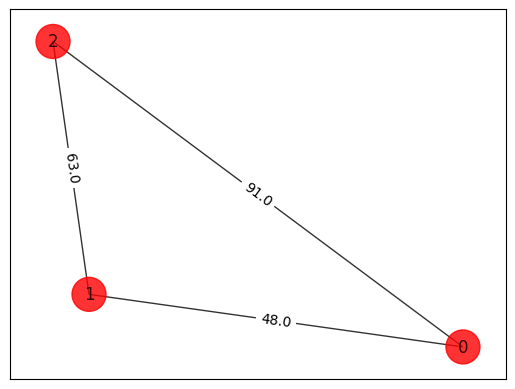

In [5]:
# Simple graph with three nodes for Traveling-Salesman-Problem (TSP) as basic introductory example
# Generating a graph of 3 nodes
n = 3 
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [6]:
#Mapping to Ising model
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [7]:
#convert to qubo (quadratic unconstrained binary optimization)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
#convert to Ising model
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIIZZI
+ 606.5 * IIIIIZIIZ
+ 12.0 * IIIIIZIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIIIZ
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIIZIZII
+ 606.5 * IIIIZZIII
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIZIIIZI
+ 606.5 * IIIZIIZII
+ 606.5 * IIIZIZIII
+ 606.5 * IIIZZIIII
+ 606.5 * IIZIIIIIZ
+ 22.75 * IIZIIIIZI
+ 22.75 * IIZIIIZII
+ 606.5 * IIZIIZIII
+ 15.75 * IIZIZIIII
+ 15.75 * IIZZIIIII
+ 22.75 * IZIIIIIIZ
+ 606.5 * IZIIIIIZI
+ 22.75 * IZIIIIZII
+ 15.75 * IZIIIZIII
+ 606.5 * IZIIZIIII
+ 15.75 * IZIZIIIII
+ 606.5 * IZZIIIIII
+ 22.75 * ZIIIIIIIZ
+ 22.75 * ZIIIIIIZI
+ 606.5 * ZIIIIIZII
+ 15.75 * ZIIIIZIII
+ 15.75 * ZIIIZIIII
+ 606.5 * ZIIZIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * ZZIIIIIII


In [8]:
#classical computation of exact solution 
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 202.0
variable values: x_0_0=1.0, x_0_1=0.0, x_0_2=0.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS


# Define qaoa (reference Prof. Dr. Gerhard Hellstern, HPI)
Starte mit einem parametrisierten Ansatz $| \Psi (\alpha, \beta, \gamma ...) \rangle$ und variere die Parameter so lange, bis das Minimum erreicht ist. Das ist die allg. Idee der sog. "Variationellen Quantenalgorithmen (VQA)".

* QAOA ist ein Spezialfall davon; hier macht man keinen möglichst allgemeinen Ansatz (mit vielen Parametern ...), sondern lässt sich beim Ansatz durch die Physik inspirieren:

* Motiviert durch das "Adiabatentheorem" (ein System bei dem man Änderungen nur langsam genug vornimmt bleibt immer in seinem Grundzustand) wird schliesslich bei QAOA folgender Ansatz gemacht:

$$ H_{final} = \alpha H_{mixer} + \beta H_{Ising}$$ mit $$ H_{mixer}=\sum_i {\hat\sigma_{x}^{(i)}}$$

In [10]:
#convert to qaoa
algorithm_globals.random_seed = 1234
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=123, seed_transpiler=123)

#prepare mixer
beta = Parameter("β")
mixer = QuantumCircuit(n**2)
for i in range(n**2):
    mixer.rx(beta, i)

#build up qaoa with mixer and solve qaoa
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(optimizer=cobyla, reps=1, mixer=mixer, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result_sv = qaoa.solve(qubo)

print_result(result_sv)

fval=202.0, x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=0.0, x_1_1=1.0, x_1_2=0.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0, status=SUCCESS
Optimal: selection [0. 0. 1. 0. 1. 0. 1. 0. 0.], value 202.0000


In [13]:
#qaoa_mes.ansatz.decompose().draw('mpl')

### Your solution

Explain which paramateres can be changed in the code below, how to get different results.

In [28]:

# Your code here: Implementation of the good solution

## Results

Analyse both solutions the naive and yours, and show what is better.
This can both be done theoretically (like Big O notation) or also some concrete results.
If possible show below some graphs to compare the 2 solutions helping to explain what makes your solution so good.

In [ ]:

# Your code here: Use code to show graphs